# 음악 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torchvision.transforms as T

import timm
from sklearn.metrics import accuracy_score

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# Custom Dataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            if cls != '.DS_Store':
                cls_path = os.path.join(root_path, cls)
                img_list = os.listdir(cls_path)
                for img in img_list:
                    if img != '.DS_Store':
                        img_path = os.path.join(cls_path, img)
                        self.data.append((img_path, i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [4]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
classes = ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/13/data/train', classes, transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/13/data/val', classes, transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part2/13/data/test', classes, transforms)

In [5]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

699 200 100


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=20, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

# training, evaluation

In [7]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(probs, 1)
        train_accuracy += (preds==labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds==labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_loss_list.append(valid_loss)
        valid_accuracy_list.append(valid_accuracy)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    return model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

# model

In [8]:
model = timm.create_model(
    'resnet18',
    pretrained=True,
    num_classes=len(classes)
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [9]:
for params in model.parameters():
    params.require_grads = False

for params in model.fc.parameters():
    params.require_grads = True

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, 30)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.8955606290272304, Train Accuracy: 0.40915593705293274, Valid Loss: 1.6526917695999146, Valid Accuracy: 0.41


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.0952981523105076, Train Accuracy: 0.6566523605150214, Valid Loss: 1.3711516991257668, Valid Accuracy: 0.535


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.7287468067237309, Train Accuracy: 0.753934191702432, Valid Loss: 1.301763718575239, Valid Accuracy: 0.59


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.553970245378358, Train Accuracy: 0.8054363376251789, Valid Loss: 1.2782738864421845, Valid Accuracy: 0.58


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.39727261662483215, Train Accuracy: 0.8783977110157367, Valid Loss: 1.6452026970684528, Valid Accuracy: 0.515


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.2559379224266325, Train Accuracy: 0.9141630901287554, Valid Loss: 1.4622677536681294, Valid Accuracy: 0.545


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.31302161301885334, Train Accuracy: 0.9012875536480687, Valid Loss: 2.1609747231006624, Valid Accuracy: 0.5


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.20768601979528153, Train Accuracy: 0.9370529327610873, Valid Loss: 1.5000597633421422, Valid Accuracy: 0.635


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.13329866624304226, Train Accuracy: 0.9656652360515021, Valid Loss: 1.5332780852913857, Valid Accuracy: 0.59


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.07873132335288184, Train Accuracy: 0.9756795422031473, Valid Loss: 1.3599985003471375, Valid Accuracy: 0.64


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.10184028820533837, Train Accuracy: 0.9756795422031473, Valid Loss: 1.6644195191562177, Valid Accuracy: 0.535


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.07679083246205534, Train Accuracy: 0.9828326180257511, Valid Loss: 1.5597044095396995, Valid Accuracy: 0.66


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.08256683841879879, Train Accuracy: 0.9785407725321889, Valid Loss: 1.659881943464279, Valid Accuracy: 0.585


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.07715308116748928, Train Accuracy: 0.9742489270386266, Valid Loss: 1.7395093485713005, Valid Accuracy: 0.61


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.10229465618197407, Train Accuracy: 0.9642346208869814, Valid Loss: 1.552814519405365, Valid Accuracy: 0.6


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.09819477839129312, Train Accuracy: 0.9699570815450643, Valid Loss: 1.9221549983136357, Valid Accuracy: 0.565


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.11497324360534548, Train Accuracy: 0.9613733905579399, Valid Loss: 1.9837887600064277, Valid Accuracy: 0.58


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0772796750866941, Train Accuracy: 0.9699570815450643, Valid Loss: 1.9762180417776107, Valid Accuracy: 0.565


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.07337521429040603, Train Accuracy: 0.977110157367668, Valid Loss: 1.9471433982253075, Valid Accuracy: 0.56


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.027224902256524987, Train Accuracy: 0.9957081545064378, Valid Loss: 1.6337935268878936, Valid Accuracy: 0.63


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.031840803314532554, Train Accuracy: 0.9914163090128756, Valid Loss: 1.926960489153862, Valid Accuracy: 0.585


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.03961448085693908, Train Accuracy: 0.9842632331902719, Valid Loss: 1.9346374325454234, Valid Accuracy: 0.605


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.040798872715926596, Train Accuracy: 0.9928469241773963, Valid Loss: 1.6661487862933426, Valid Accuracy: 0.61


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.02124987972035472, Train Accuracy: 0.994277539341917, Valid Loss: 1.8570404089987278, Valid Accuracy: 0.625


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.012380516740293907, Train Accuracy: 0.994277539341917, Valid Loss: 1.5367435976862907, Valid Accuracy: 0.64


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.015273295542491334, Train Accuracy: 0.9928469241773963, Valid Loss: 2.118405217677355, Valid Accuracy: 0.585


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.013448154790759352, Train Accuracy: 0.9971387696709585, Valid Loss: 1.5675037898123265, Valid Accuracy: 0.61


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.016273051069583745, Train Accuracy: 0.9928469241773963, Valid Loss: 1.8542333997786045, Valid Accuracy: 0.605


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.01021928393913965, Train Accuracy: 0.9985693848354793, Valid Loss: 1.8024898894131183, Valid Accuracy: 0.65


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.00983489482646941, Train Accuracy: 0.9971387696709585, Valid Loss: 1.7395620577037334, Valid Accuracy: 0.64


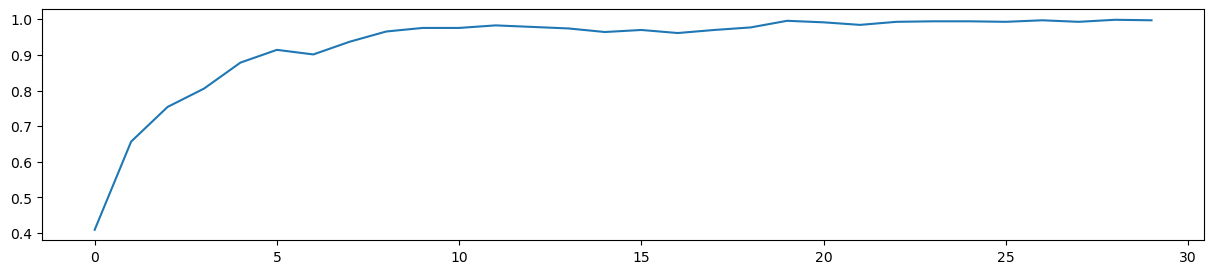

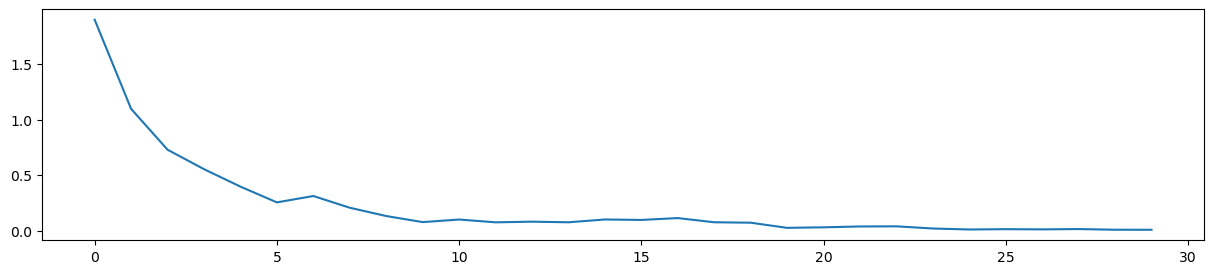

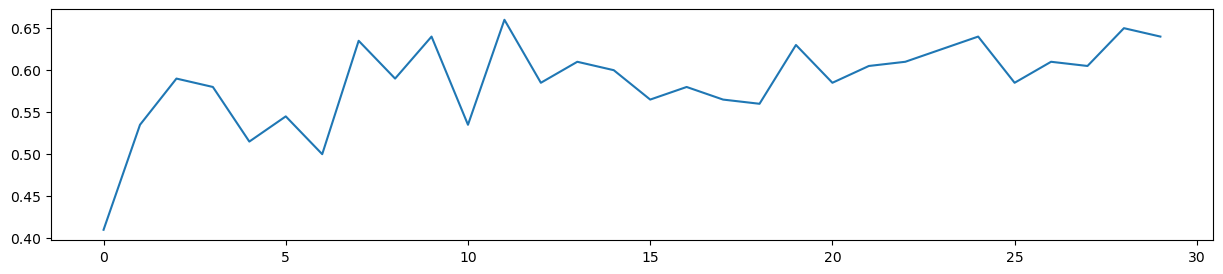

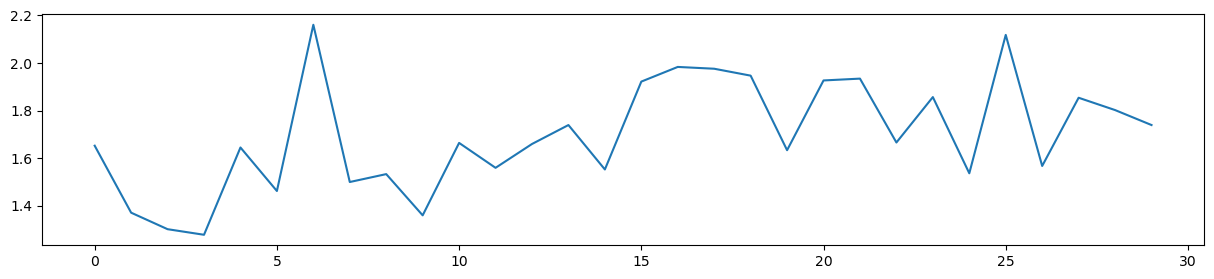

In [18]:
plt.figure(figsize=(15, 3))
plt.plot(train_accuracy_list)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_loss_list)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(valid_accuracy_list)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(valid_loss_list)
plt.show()

# test

In [21]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
print(total_labels)
print(total_preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 6, 6, 1, 2, 1, 7, 1, 1, 6, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 9, 4, 3, 9, 5, 4, 8, 6, 9, 6, 4, 2, 4, 4, 4, 0, 8, 4, 0, 2, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 1, 6, 1, 9, 1, 6, 1, 6, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 6, 8, 8, 6, 8, 8, 8, 2, 9, 9, 9, 9, 5, 9, 9, 0, 9, 0]


In [24]:
accuracy_score(total_labels, total_preds)

0.63